<a href="https://colab.research.google.com/github/KarmanyaGupta1421/Compfinance/blob/main/comp_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [240]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [241]:
api_key = '7P986FG62D96JCCW'
symbol = 'IBM'
interval = '1min'
year = '2023'
month = '12'

#### API call to download data

In [242]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&month={year}-{month}&outputsize=full&apikey={api_key}&datatype=json'
# print(url)

response = requests.get(url)
data = response.json()

with open ('data.json', 'w') as f:
  json.dump(data, f)
# print(data)
time_series = data[f"Time Series (1min)"]

#### Creating a Data Frame of the extracted data

In [243]:
df = pd.DataFrame.from_dict(time_series, orient="index")
df.columns = ["Open", "High", "Low", "Close", "Volume"]
df.index = pd.to_datetime(df.index)
df = df.astype(float)
print(df.head())

                        Open     High      Low    Close  Volume
2023-12-29 19:59:00  162.017  162.033  161.830  161.853    60.0
2023-12-29 19:55:00  162.027  162.042  162.018  162.041     5.0
2023-12-29 19:53:00  161.918  162.181  161.909  162.041   152.0
2023-12-29 19:42:00  162.027  162.042  162.018  162.041     1.0
2023-12-29 19:41:00  161.829  161.844  161.820  161.843   100.0


# Moving Averages
Moving average, also called Rolling average, is simply the mean or average of the specified data field for a given set of consecutive periods. As new data becomes available, the mean of the data is computed by dropping the oldest value and adding the latest one.

So, in essence, the mean or average is rolling along with the data, hence the name 'Moving Average'.

In [244]:
def SMA(data, ndays):
    SMA = pd.Series(data['Close'].rolling(ndays).mean(), name = 'SMA')
    data = data.join(SMA)
    return data

def EWMA(data, ndays):
  EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean(), name = 'EWMA_' + str(ndays))
  data = data.join(EMA)
  return data

In [245]:
n = 50
sma = SMA(df,n)
sma = sma.dropna()
sma = sma['SMA']


ew = 200
ewma = EWMA(df,ew)
ewma = ewma.dropna()
ewma = ewma['EWMA_200']

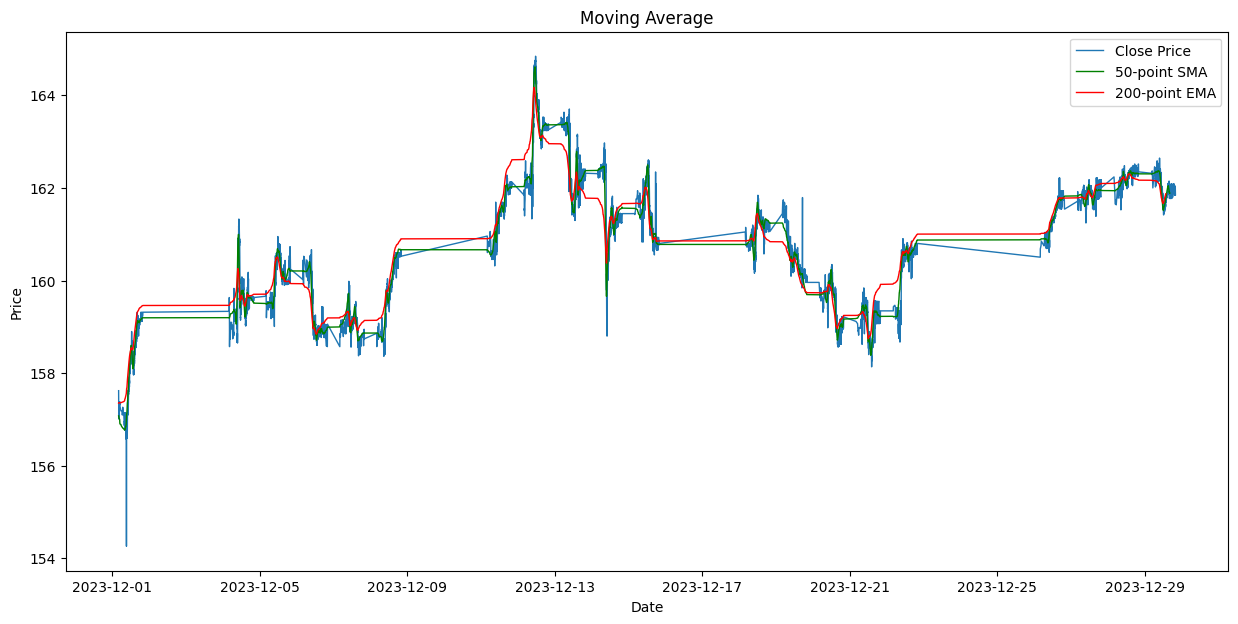

In [246]:
plt.figure(figsize=(15,7))
# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(df['Close'],lw=1, label='Close Price')
plt.plot(sma,'g',lw=1, label='50-point SMA')
plt.plot(ewma,'r', lw=1, label='200-point EMA')

plt.legend()

plt.show()

# Money Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

Unlike conventional oscillators such as the Relative Strength Index (RSI), the Money Flow Index incorporates both price and volume data, as opposed to just price.

In [247]:
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def MFI(high, low, close, volume, n=14):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign

    # Calculate gain and loss using vectorized operations
    positive_mf = np.where(signed_mf > 0, signed_mf, 0)
    negative_mf = np.where(signed_mf < 0, -signed_mf, 0)

    mf_avg_gain = pd.Series(positive_mf).rolling(n, min_periods=1).sum()
    mf_avg_loss = pd.Series(negative_mf).rolling(n, min_periods=1).sum()

    return (100 - 100 / (1 + mf_avg_gain / mf_avg_loss)).to_numpy()

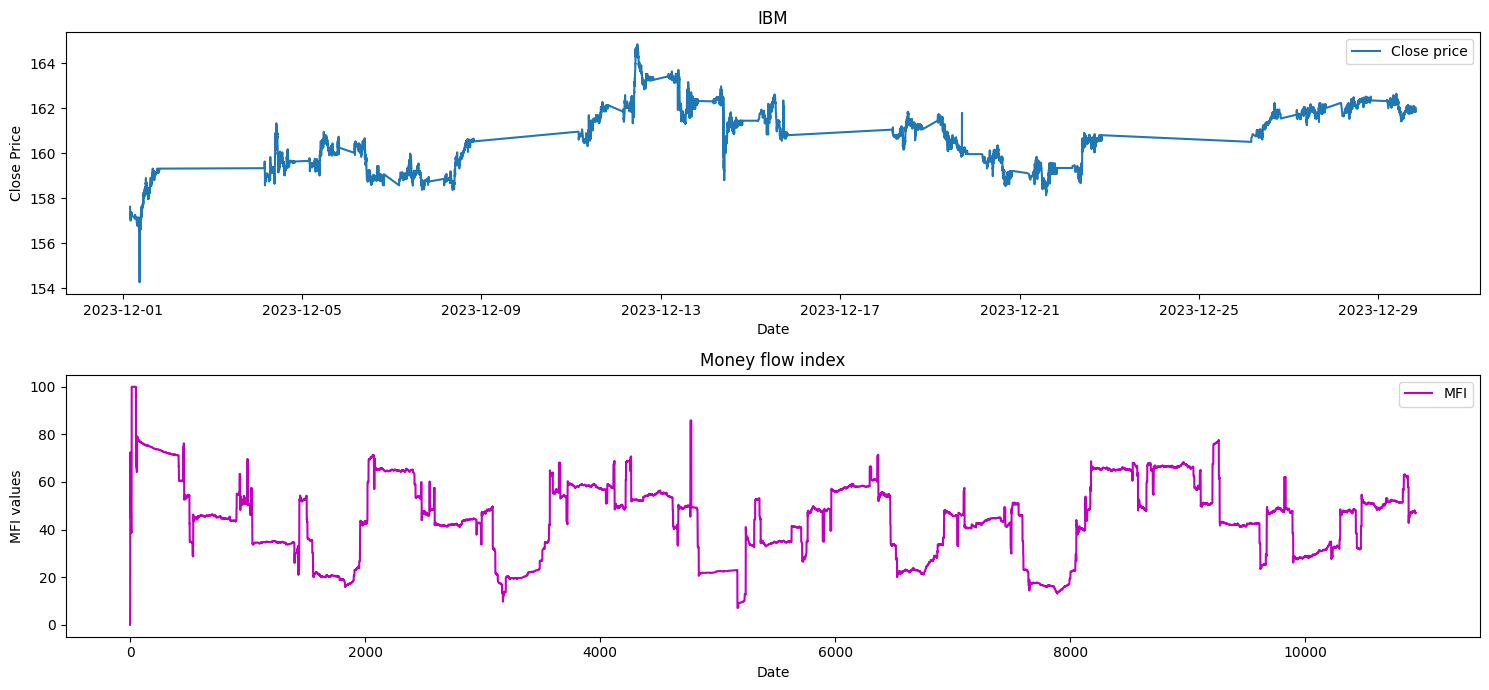

In [250]:
mfi = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 400)

fig = plt.figure(figsize=(15, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)

# Set the title and axis labels
plt.title('IBM')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(df['Close'], label='Close price')

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Money flow index')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(mfi, 'm', label='MFI')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

# Prediction using Moving Average

In [252]:
#Creatig a new DF
new_data = pd.DataFrame(index=df.index, columns = ['Close'])
new_data['Close'] = df['Close']

print(new_data.head())

                       Close
2023-12-29 19:59:00  161.853
2023-12-29 19:55:00  162.041
2023-12-29 19:53:00  162.041
2023-12-29 19:42:00  162.041
2023-12-29 19:41:00  161.843



 Shape of training set: (7442, 1)

 Shape of validation set: (3500, 1)


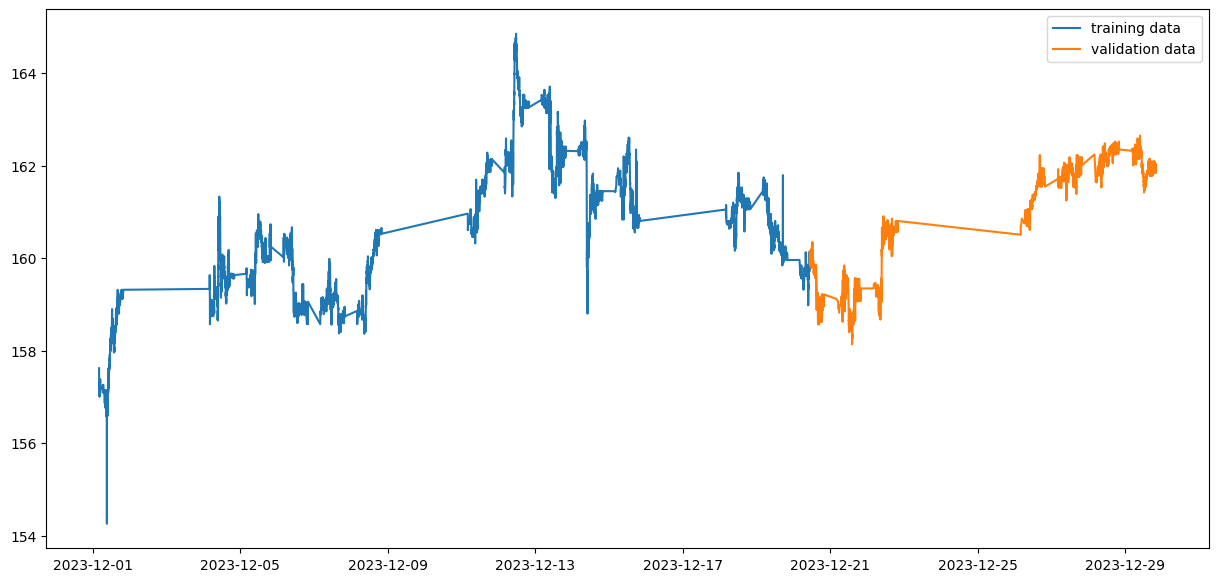

In [253]:
# Splitting data into train data and validation data
validation_size = 3500
train = new_data[validation_size:]
valid = new_data[:validation_size]

plt.figure(figsize=(15,7))
plt.plot(train['Close'], label='training data')
plt.plot(valid['Close'], label='validation data')
plt.legend()

# shapes of training set
print('\n Shape of training set:', train.shape)

# shapes of validation set
print('\n Shape of validation set:', valid.shape)

In [254]:
#Predicting the future values
predicted_value = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-validation_size+i:].sum() + sum(predicted_value)
    b = a/validation_size
    predicted_value.append(b)

rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-predicted_value),2)))
print(f'Root mean squared error : {round(rms,3)}')

Root mean squared error : 1.99


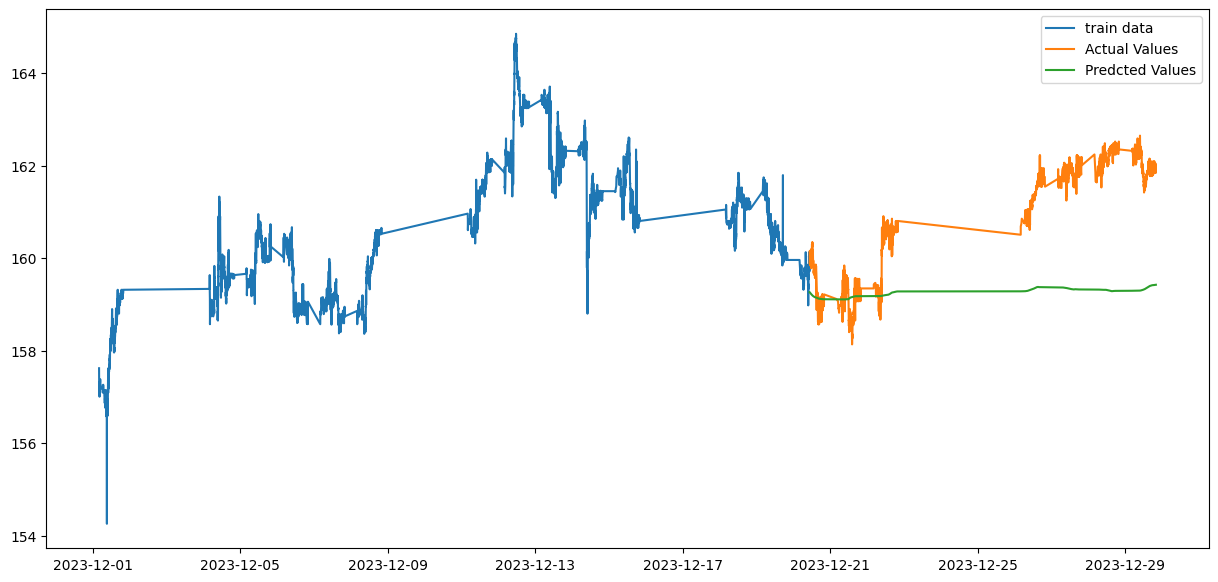

In [255]:
#plot
valid = valid.assign(Predictions = predicted_value)
plt.figure(figsize=(15,7))
plt.plot(train['Close'], label = 'train data')
plt.plot(valid['Close'], label = 'Actual Values')
plt.plot(valid['Predictions'], label = 'Predcted Values')
plt.legend()

# Prediction using Linear Regression

## Features used for initial Linear Regression model
- Day
- Day of the week
- Hour
- Minute

In [256]:
#Creatig a new DF
new_data = pd.DataFrame(index=df.index, columns = ['Close'])
new_data['Close'] = df['Close']

new_data['date'] = new_data.index.day
new_data['hour'] = new_data.index.hour
new_data['minute'] = new_data.index.minute
new_data['day_of_week'] = new_data.index.day_of_week

new_data.dropna(inplace=True)

print(new_data.head())

# Splitting data into train data and validation data
validation_size = 3500
train = new_data[validation_size:]
valid = new_data[:validation_size]

# shapes of training set
print('\n Shape of training set:', train.shape)

# shapes of validation set
print('\n Shape of validation set:', valid.shape)

                       Close  date  hour  minute  day_of_week
2023-12-29 19:59:00  161.853    29    19      59            4
2023-12-29 19:55:00  162.041    29    19      55            4
2023-12-29 19:53:00  162.041    29    19      53            4
2023-12-29 19:42:00  162.041    29    19      42            4
2023-12-29 19:41:00  161.843    29    19      41            4

 Shape of training set: (7442, 5)

 Shape of validation set: (3500, 5)


In [257]:
#Training the Model
y_train = train['Close']
x_train = train.drop('Close', axis=1)
y_valid = valid['Close']
x_valid = valid.drop('Close', axis=1)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

Root mean squared error: 1.8394772220055953


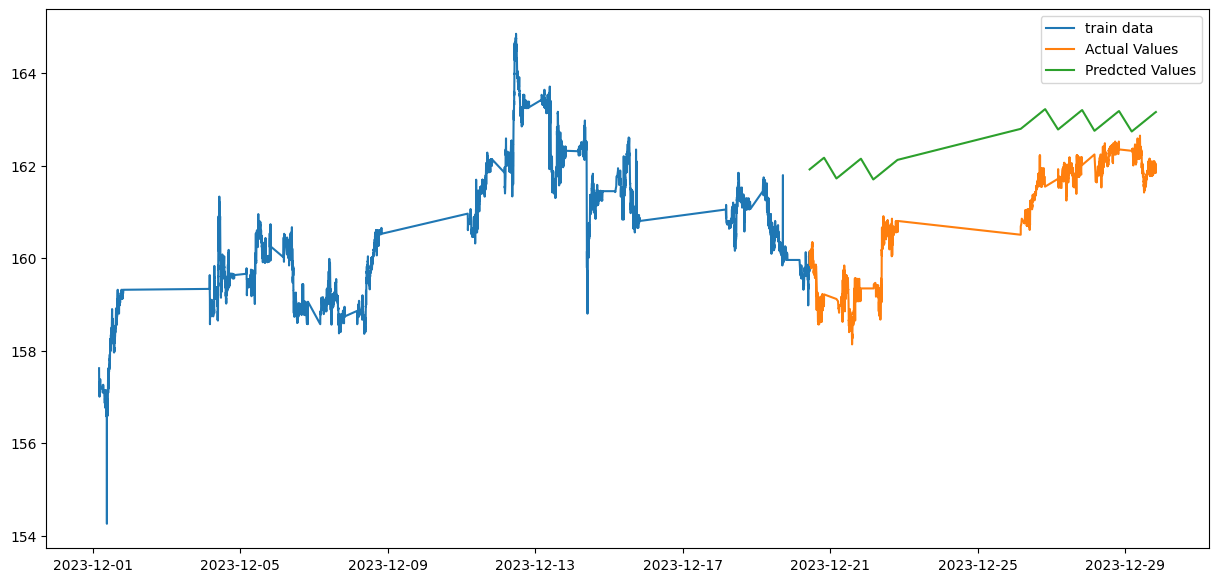

In [258]:
#Predicting values based on the trained model
predicted_value = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(predicted_value)),2)))
print(f'Root mean squared error: {rms}')

#plot the results
valid = valid.assign(Predictions = predicted_value)
plt.figure(figsize=(15,7))
plt.plot(train['Close'], label = 'train data')
plt.plot(valid['Close'], label = 'Actual Values')
plt.plot(valid['Predictions'], label = 'Predcted Values')
plt.legend()

## Adding Simple Moving Average Data to our model

In [262]:
#Creatig a new DF
new_data = pd.DataFrame(index=df.index, columns = ['Close'])
new_data['Close'] = df['Close']

new_data['date'] = new_data.index.day
new_data['hour'] = new_data.index.hour
new_data['minute'] = new_data.index.minute
new_data['day_of_week'] = new_data.index.day_of_week
new_data['sma_20'] = new_data['Close'].rolling(20).mean()
new_data['sma_100'] = new_data['Close'].rolling(100).mean()

new_data.dropna(inplace=True)

print(new_data.head())

# Splitting data into train data and validation data
validation_size = 3500
train = new_data[validation_size:]
valid = new_data[:validation_size]

# shapes of training set
print('\n Shape of training set:', train.shape)

# shapes of validation set
print('\n Shape of validation set:', valid.shape)

                       Close  date  hour  minute  day_of_week     sma_20  \
2023-12-29 15:21:00  161.952    29    15      21            4  162.04230   
2023-12-29 15:20:00  161.942    29    15      20            4  162.03475   
2023-12-29 15:19:00  161.972    29    15      19            4  162.02955   
2023-12-29 15:18:00  162.031    29    15      18            4  162.03005   
2023-12-29 15:17:00  162.081    29    15      17            4  162.03355   

                       sma_100  
2023-12-29 15:21:00  161.96291  
2023-12-29 15:20:00  161.96380  
2023-12-29 15:19:00  161.96311  
2023-12-29 15:18:00  161.96301  
2023-12-29 15:17:00  161.96341  

 Shape of training set: (7343, 7)

 Shape of validation set: (3500, 7)


In [263]:
#Training the Model
y_train = train['Close']
x_train = train.drop('Close', axis=1)
y_valid = valid['Close']
x_valid = valid.drop('Close', axis=1)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [267]:
a = x_valid.iloc[0].values.reshape(1,-1)
print(a)
a_df = pd.DataFrame(a, columns = list(x_valid))
# print(a_df)
d = model.predict(a_df)[0]
print(d)

[[ 29.       15.       21.        4.      162.0423  161.96291]]
162.0793388394962


Root mean squared error: 0.13196998361806014


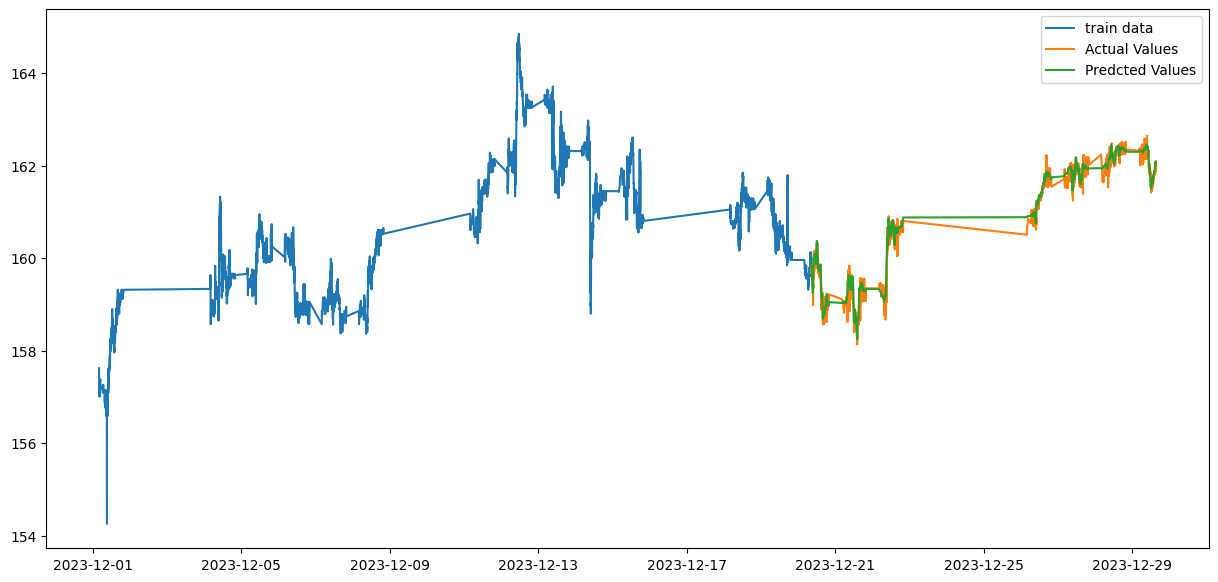

In [268]:
#Predicting values based on the trained model
predicted_value = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(predicted_value)),2)))
print(f'Root mean squared error: {rms}')

# print(predicted_values[2000])

#plot the results
valid = valid.assign(Predictions = predicted_value)
plt.figure(figsize=(15,7))
plt.plot(train['Close'], label = 'train data')
plt.plot(valid['Close'], label = 'Actual Values')
plt.plot(valid['Predictions'], label = 'Predcted Values')
plt.legend()

We observe that the RMS value improves after adding the data of SWA. Now we will add the data of EWM to see if the model further improves

In [269]:
#Creatig a new DF
new_data = pd.DataFrame(index=df.index, columns = ['Close'])
new_data['Close'] = df['Close']

new_data['date'] = new_data.index.day
new_data['hour'] = new_data.index.hour
new_data['minute'] = new_data.index.minute
new_data['day_of_week'] = new_data.index.day_of_week
new_data['sma_20'] = new_data['Close'].rolling(20).mean()
new_data['sma_100'] = new_data['Close'].rolling(100).mean()
new_data['ewm_20'] = new_data['Close'].ewm(span=20).mean()
new_data['ewm_100'] = new_data['Close'].ewm(span=100).mean()
new_data.dropna(inplace=True)

print(new_data.head())

# Splitting data into train data and validation data
validation_size = 3500
train = new_data[validation_size:]
valid = new_data[:validation_size]

# shapes of training set
print('\n Shape of training set:', train.shape)

# shapes of validation set
print('\n Shape of validation set:', valid.shape)

                       Close  date  hour  minute  day_of_week     sma_20  \
2023-12-29 15:21:00  161.952    29    15      21            4  162.04230   
2023-12-29 15:20:00  161.942    29    15      20            4  162.03475   
2023-12-29 15:19:00  161.972    29    15      19            4  162.02955   
2023-12-29 15:18:00  162.031    29    15      18            4  162.03005   
2023-12-29 15:17:00  162.081    29    15      17            4  162.03355   

                       sma_100      ewm_20     ewm_100  
2023-12-29 15:21:00  161.96291  162.032839  161.996010  
2023-12-29 15:20:00  161.96380  162.024187  161.994777  
2023-12-29 15:19:00  161.96311  162.019217  161.994259  
2023-12-29 15:18:00  161.96301  162.020339  161.995093  
2023-12-29 15:17:00  161.96341  162.026116  161.997037  

 Shape of training set: (7343, 9)

 Shape of validation set: (3500, 9)


In [270]:
#Training the Model
y_train = train['Close']
x_train = train.drop('Close', axis=1)
y_valid = valid['Close']
x_valid = valid.drop('Close', axis=1)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

Root mean squared error: 0.08295813843443921


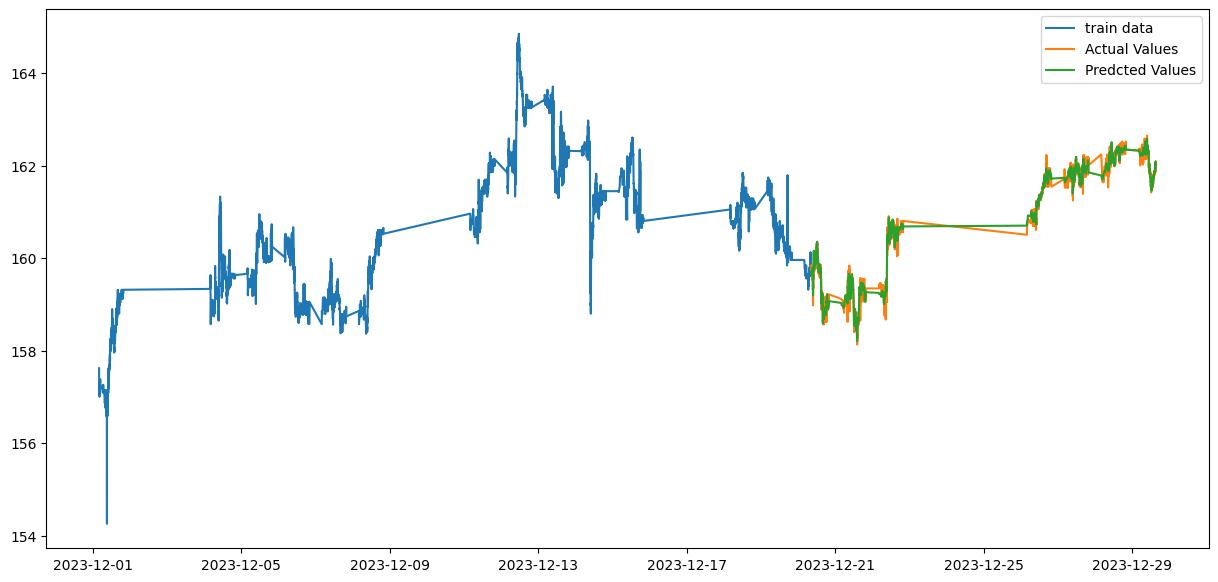

In [271]:
#Predicting values based on the trained model
predicted_value = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(predicted_value)),2)))
print(f'Root mean squared error: {rms}')

#plot the results
valid = valid.assign(Predictions = predicted_value)
plt.figure(figsize=(15,7))
plt.plot(train['Close'], label = 'train data')
plt.plot(valid['Close'], label = 'Actual Values')
plt.plot(valid['Predictions'], label = 'Predcted Values')
plt.legend()

Clearly, adding more data improves the RMS value thus, further improving the model.